# Importing resources

In [2]:
conda install pip

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tweepy

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import requests
import os
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt

# Gather

1. The WeRateDogs Twitter archive  

In [5]:
#Read the twitter archive file on hand
twitter_archive_df=pd.read_csv('twitter-archive-enhanced.csv')

2. The tweet image predictions

In [6]:
#Download the image predictions file programmatically
url= "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response=requests.get(url)


#Creating a folder titled Image_Predictions
folder_name = 'Image_Predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
#Locate the file in the project folder
with open(os.path.join(url.split('/')[-1]),mode='wb') as file:
    file.write(response.content)
    
#Read TSV file
image_prediction_df = pd.read_csv('image-predictions.tsv', sep='\t' )    

3. Each tweet's retweet count and favorite 

In [ ]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:t
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [7]:
lines=[]
with open('tweet-json.txt','rt') as file:
    for line in file:
        lines.append(line)

# Extracting data from each line.
df_list=[]
for line in lines:
    #tweet ID
    x=line.find('id_str')
    tweet_id=line[x+10:x+28]
    #retweet count
    x=line.find("retweet_count")
    retweet_count=line[x+16:x+20]
    #favorite count
    x=line.find('favorite_count')
    favorite_count=line[x+17:x+22]
    
    # Append to list of dictionaries
    df_list.append({'tweet_id': tweet_id,'retweet_count': retweet_count,'favorite_count': favorite_count})

#Converting to dataframe    
tweet_json_df=pd.DataFrame(df_list,columns=['tweet_id','retweet_count','favorite_count'])

# Assess

In [5]:
#visually assessing the twitter archive 
twitter_archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [6]:
#See sumary of twitter archive dataframe
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

Quality issue: NaN values are written None in name, doggo, floofer, pupper & puppo coloumns

Quality issue: 181 retweets

In [7]:
#count the values in name coloumn
twitter_archive_df['name'].value_counts()

None        745
a            55
Charlie      12
Oliver       11
Cooper       11
           ... 
Ashleigh      1
Pip           1
Wiggles       1
Tilly         1
Rudy          1
Name: name, Length: 957, dtype: int64

Quality issue: name "a" is  not valid

In [8]:
#Check for duplicates 
sum(twitter_archive_df['tweet_id'].duplicated())

0

In [9]:
#check numerators values
twitter_archive_df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [10]:
#Check the lines including zero in numerator
print(twitter_archive_df.loc[twitter_archive_df.rating_numerator == 0, 'text']) 

315     When you're so blinded by your systematic plag...
1016    PUPDATE: can't see any. Even if I could, I cou...
Name: text, dtype: object


Quality issue: There are 2 zero numerators hence no rating in lines 3015 and 1016

In [11]:
#Check denominator values
twitter_archive_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [12]:
#Check the non-ten denominator values
x=(11,50,80,20,2,16,40,70,15,90,110,120,130,150,170,7)
for i in x:
    print(twitter_archive_df.loc[twitter_archive_df.rating_denominator == i, 'text'])

784     RT @dog_rates: After so many requests, this is...
1068    After so many requests, this is Bretagne. She ...
1662    This is Darrel. He just robbed a 7/11 and is i...
Name: text, dtype: object
1202    This is Bluebert. He just saw that both #Final...
1274    From left to right:\nCletus, Jerome, Alejandro...
1351    Here is a whole flock of puppers.  60/50 I'll ...
Name: text, dtype: object
1254    Here's a brigade of puppers. All look very pre...
1843    Here we have an entire platoon of puppers. Tot...
Name: text, dtype: object
1165    Happy 4/20 from the squad! 13/10 for all https...
1598    Yes I do realize a rating of 4/20 would've bee...
Name: text, dtype: object
2335    This is an Albanian 3 1/2 legged  Episcopalian...
Name: text, dtype: object
1663    I'm aware that I could've said 20/16, but here...
Name: text, dtype: object
1433    Happy Wednesday here's a bucket of pups. 44/40...
Name: text, dtype: object
433    The floofs have been released I repeat the flo...
Name: t

In [13]:
#checking the full text for the non-ten denominator
print(twitter_archive_df['text'][784])#retweet
print(twitter_archive_df['text'][1068])#should be 14/10
print(twitter_archive_df['text'][1662])#should be 10/10
print(twitter_archive_df['text'][1202])#should be 11/10
print(twitter_archive_df['text'][1274])#No rating
print(twitter_archive_df['text'][1351])#five dogs in photo 
print(twitter_archive_df['text'][1254])#five dogs in photo
print(twitter_archive_df['text'][1843])#Eight dogs in photo 
print(twitter_archive_df['text'][1165])#shoud be 13/10
print(twitter_archive_df['text'][1598])#Not link to post 
print(twitter_archive_df['text'][2335])#should be 9/10
print(twitter_archive_df['text'][1663])#No link to post
print(twitter_archive_df['text'][1433])#four dogs
print(twitter_archive_df['text'][433])#No idea why!

RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
From left to right:
Cletus, Jerome, Alejandro, Burp, &amp; Titson
None know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK
Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa
Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw
Happy 4/20 from

Quality issue: non-ten denominator

note: When denominator is greater than 10 there are usualy multiple dogs in the photo. ie: when denominator is 50 there are 5 dogs in the picture

Tideness issue: doggo, floofer, pupper and puppo in separate coloumns representing dog stage

Tideness issue: Rating coloumn should be there

In [14]:
#visually assessing the image predictions 
image_prediction_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [15]:
#See sumary of image predictions dataframe
image_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
#Check for duplicates 
sum(image_prediction_df.jpg_url.duplicated())

66

Quality issue: 66 image duplicates

Tidiness issue: multiple couloumns representing image prediction and confidence level

In [17]:
#visually assessing the tweet json 
tweet_json_df

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,"41,","111,"
2350,666044226329800704,"147,","311,"
2351,666033412701032449,"47,","128,"
2352,666029285002620928,"48,","132,"


In [18]:
#See sumary of tweet json dataframe
tweet_json_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   object
 2   favorite_count  2354 non-null   object
dtypes: object(3)
memory usage: 55.3+ KB


Quality issue: data type for tweet_id is objects not int

# Summary of Assessment

### Quality Issues

twitter_archive_df
1. 181 retweets 
2. NaN values are written None in name coloumn
3. name "a" is  not valid
4. NaN values are written None in doggo, floofer, pupper & puppo coloumns
5. There are 2 zero numerators hence no rating in lines 3015 and 1016
6. non-ten denominator
7. Useless coloumns for analysis ('Source','in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','expanded_urls')      

image_prediction_df

8. 66 image duplicates
9. many predection values

tweet_json_df

10. data type for tweet_id is object not int

### Tideness Issues

twitter_archive_df
1. doggo, floofer, pupper and puppo in separate coloumns representing dog stage
2. Overall rating coloumn should be there

Overall

3. All tables should be part of one dataset


# Cleaning

In [8]:
#Creating copies of dataframes to save cleaned
twitter_archive_df_clean = twitter_archive_df.copy()
image_prediction_df_clean = image_prediction_df.copy()
tweet_json_df_clean = tweet_json_df.copy()

### Quality Issues

#### twitter_archive_df

1. Remove retweets

In [9]:
#Define
#Remove non-NaN retweet_status_user_id rows

#Code
twitter_archive_df_clean = twitter_archive_df_clean[(twitter_archive_df_clean['retweeted_status_user_id']).isnull()]

#Test
print(sum(twitter_archive_df_clean.retweeted_status_user_id.value_counts()))

0


2. Replace all none value to NaN

In [10]:
#Define
# replace none with NaN

#Code
twitter_archive_df_clean['name'].replace('None', np.nan, inplace=True)

#Test
twitter_archive_df_clean['name'].value_counts()

a          55
Lucy       11
Charlie    11
Cooper     10
Oliver     10
           ..
Sephie      1
Tuck        1
Rhino       1
Batdog      1
Thor        1
Name: name, Length: 955, dtype: int64

3. Replace a with NaN 

In [11]:
#Define
#replace a with NaN

#CODE
twitter_archive_df_clean['name'].replace('a', np.nan, inplace=True)

#Test
twitter_archive_df_clean['name'].value_counts()

Charlie    11
Lucy       11
Oliver     10
Cooper     10
Tucker      9
           ..
Tuck        1
Rhino       1
Batdog      1
Vinnie      1
Thor        1
Name: name, Length: 954, dtype: int64

4. Replace "0" numerator with NaN

In [12]:
#first check the values in numerator after the cleaning process above
twitter_archive_df_clean['rating_numerator'].value_counts()

12      500
10      442
11      426
13      307
9       156
8        98
7        54
14       43
5        36
6        32
3        19
4        17
2         9
1         8
420       2
0         2
20        1
24        1
26        1
84        1
44        1
50        1
60        1
80        1
165       1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
15        1
17        1
27        1
45        1
75        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [13]:
#Define
#Replace 0 with NaN

#Code
twitter_archive_df_clean['rating_numerator'].replace(0, np.nan, inplace=True)

#Test
twitter_archive_df_clean['rating_numerator'].value_counts()

12.0      500
10.0      442
11.0      426
13.0      307
9.0       156
8.0        98
7.0        54
14.0       43
5.0        36
6.0        32
3.0        19
4.0        17
2.0         9
1.0         8
420.0       2
17.0        1
15.0        1
960.0       1
84.0        1
24.0        1
27.0        1
143.0       1
50.0        1
666.0       1
121.0       1
182.0       1
165.0       1
45.0        1
75.0        1
204.0       1
1776.0      1
99.0        1
88.0        1
144.0       1
26.0        1
20.0        1
44.0        1
60.0        1
80.0        1
Name: rating_numerator, dtype: int64

5. Correct non-ten denominator

In [14]:
#Get tweet_id for correction
print(twitter_archive_df['tweet_id'][1068])#should be 14/10
print(twitter_archive_df['tweet_id'][1662])#should be 10/10
print(twitter_archive_df['tweet_id'][1202])#should be 11/10
print(twitter_archive_df['tweet_id'][1165])#shoud be 13/10
print(twitter_archive_df['tweet_id'][2335])#should be 9/10

740373189193256964
682962037429899265
716439118184652801
722974582966214656
666287406224695296


In [15]:
#Change data type to float to allow dicemal 
twitter_archive_df_clean[['rating_numerator', 'rating_denominator']] = twitter_archive_df_clean[['rating_numerator','rating_denominator']].astype(float)

In [16]:
#Define
#Update the numerator and denominators detected

#Code
twitter_archive_df_clean.loc[(twitter_archive_df_clean.tweet_id == 740373189193256964), 'rating_numerator'] = 14
twitter_archive_df_clean.loc[(twitter_archive_df_clean.tweet_id == 740373189193256964), 'rating_denominator'] = 10

twitter_archive_df_clean.loc[(twitter_archive_df_clean.tweet_id == 682962037429899265), 'rating_numerator'] = 10
twitter_archive_df_clean.loc[(twitter_archive_df_clean.tweet_id == 682962037429899265), 'rating_denominator'] = 10

twitter_archive_df_clean.loc[(twitter_archive_df_clean.tweet_id == 666287406224695296), 'rating_numerator'] = 9
twitter_archive_df_clean.loc[(twitter_archive_df_clean.tweet_id == 666287406224695296), 'rating_denominator'] = 10

twitter_archive_df_clean.loc[(twitter_archive_df_clean.tweet_id == 722974582966214656), 'rating_numerator'] = 13
twitter_archive_df_clean.loc[(twitter_archive_df_clean.tweet_id == 722974582966214656), 'rating_denominator'] = 10

twitter_archive_df_clean.loc[(twitter_archive_df_clean.tweet_id == 716439118184652801), 'rating_numerator'] = 11
twitter_archive_df_clean.loc[(twitter_archive_df_clean.tweet_id == 716439118184652801), 'rating_denominator'] = 10

#Test
#Check denominator values
twitter_archive_df_clean.rating_denominator.value_counts()

10.0     2158
50.0        2
80.0        2
150.0       1
110.0       1
90.0        1
130.0       1
70.0        1
170.0       1
120.0       1
16.0        1
20.0        1
40.0        1
7.0         1
15.0        1
0.0         1
Name: rating_denominator, dtype: int64

In [17]:
#Define
#Replace 0 with NaN

#Code
twitter_archive_df_clean['rating_denominator'].replace(0, np.nan, inplace=True)

#Test
twitter_archive_df_clean['rating_denominator'].value_counts()

10.0     2158
50.0        2
80.0        2
150.0       1
110.0       1
90.0        1
130.0       1
70.0        1
170.0       1
120.0       1
16.0        1
20.0        1
40.0        1
7.0         1
15.0        1
Name: rating_denominator, dtype: int64

In [18]:
#check the 7 and 15
print(twitter_archive_df_clean.loc[twitter_archive_df_clean.rating_denominator == 7])
print(twitter_archive_df_clean.loc[twitter_archive_df_clean.rating_denominator == 15])

               tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
516  810984652412424192                    NaN                  NaN   

                     timestamp  \
516  2016-12-19 23:06:23 +0000   

                                                source  \
516  <a href="http://twitter.com/download/iphone" r...   

                                                  text  retweeted_status_id  \
516  Meet Sam. She smiles 24/7 &amp; secretly aspir...                  NaN   

     retweeted_status_user_id retweeted_status_timestamp  \
516                       NaN                        NaN   

                                         expanded_urls  rating_numerator  \
516  https://www.gofundme.com/sams-smile,https://tw...              24.0   

     rating_denominator name doggo floofer pupper puppo  
516                 7.0  Sam  None    None   None  None  
               tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
342  832088576586297345           8.320875e+17     

In [19]:
print(twitter_archive_df['text'][516])
print(twitter_archive_df['text'][342])

Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
@docmisterio account started on 11/15/15


Quality issue: No rating!

Replace 7 and 15 with NaN

In [20]:
#Define
#Replace 7 and 15 with NaN

#Code
twitter_archive_df_clean['rating_denominator'].replace(7, np.nan, inplace=True)
twitter_archive_df_clean['rating_denominator'].replace(15, np.nan, inplace=True)

#Test
twitter_archive_df_clean['rating_denominator'].value_counts()

10.0     2158
50.0        2
80.0        2
150.0       1
110.0       1
130.0       1
70.0        1
170.0       1
120.0       1
16.0        1
20.0        1
40.0        1
90.0        1
Name: rating_denominator, dtype: int64

6. Remove Useless coloumns not useful for analysis

In [21]:
#Define
#Remoce columns no needed

#Code
twitter_archive_df_clean = twitter_archive_df_clean.drop(['source',
                                                    'in_reply_to_status_id',
                                                    'in_reply_to_user_id',
                                                    'retweeted_status_id',
                                                    'retweeted_status_user_id', 
                                                    'retweeted_status_timestamp'], 1)

#Test
twitter_archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2175 non-null   int64  
 1   timestamp           2175 non-null   object 
 2   text                2175 non-null   object 
 3   expanded_urls       2117 non-null   object 
 4   rating_numerator    2173 non-null   float64
 5   rating_denominator  2172 non-null   float64
 6   name                1440 non-null   object 
 7   doggo               2175 non-null   object 
 8   floofer             2175 non-null   object 
 9   pupper              2175 non-null   object 
 10  puppo               2175 non-null   object 
dtypes: float64(2), int64(1), object(8)
memory usage: 203.9+ KB


#### image_prediction_df

7. Remove duplicates

In [22]:
#Define
#Remove jpg_url duplicates 

#Code
image_prediction_df_clean = image_prediction_df_clean.drop_duplicates(subset=['jpg_url'], keep='last')

#Test
sum(image_prediction_df_clean['jpg_url'].duplicated())

0

#### tweet_json_df

8. Modify data type for tweet_id to be int64 not object

In [25]:
#Define
#Change data type to int

#Code
tweet_json_df_clean['tweet_id'] = tweet_json_df_clean['tweet_id'].astype(dtype="string")

#Test
print(tweet_json_df_clean['tweet_id'].dtypes)

string


9. Get the true predection in one colomn and its conf. level in one colomn and remove the others

In [26]:
#Define
#Create two new lists


#Code

dog_type = []
confidence_list = []

#First true predection is taken 
def image(image_prediction_df_clean):
    if image_prediction_df_clean['p1_dog'] == True:
        dog_type.append(image_prediction_df_clean['p1'])
        confidence_list.append(image_prediction_df_clean['p1_conf'])
    elif image_prediction_df_clean['p2_dog'] == True:
        dog_type.append(image_prediction_df_clean['p2'])
        confidence_list.append(image_prediction_df_clean['p2_conf'])
    elif image_prediction_df_clean['p3_dog'] == True:
        dog_type.append(image_prediction_df_clean['p3'])
        confidence_list.append(image_prediction_df_clean['p3_conf'])
    else:
        dog_type.append('Error')
        confidence_list.append('Error')

#series objects having index the image_prediction_clean column.        
image_prediction_df_clean.apply(image, axis=1)

#create new columns
image_prediction_df_clean['dog_type'] = dog_type
image_prediction_df_clean['confidence_list'] = confidence_list


#remove rows that has prediction_list 'error'
image_prediction_df_clean = image_prediction_df_clean[image_prediction_df_clean['dog_type'] != 'Error']

#remove the predections colomns
image_prediction_df_clean = image_prediction_df_clean.drop(['p1', 
                                                      'p1_conf', 'p1_dog', 
                                                      'p2', 'p2_conf', 
                                                      'p2_dog', 'p3', 
                                                      'p3_conf', 
                                                      'p3_dog'], 1)

#Test
image_prediction_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1691 entries, 0 to 2073
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         1691 non-null   int64 
 1   jpg_url          1691 non-null   object
 2   img_num          1691 non-null   int64 
 3   dog_type         1691 non-null   object
 4   confidence_list  1691 non-null   object
dtypes: int64(2), object(3)
memory usage: 79.3+ KB


### Tideness Issues

#### twitter_archive_df

1. doggo, floofer, pupper and puppo into one coloumn "dog_stage"

In [96]:
twitter_archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2175 non-null   int64  
 1   timestamp           2175 non-null   object 
 2   text                2175 non-null   object 
 3   expanded_urls       2117 non-null   object 
 4   rating_numerator    2173 non-null   float64
 5   rating_denominator  2172 non-null   float64
 6   name                1440 non-null   object 
 7   doggo               2175 non-null   object 
 8   floofer             2175 non-null   object 
 9   pupper              2175 non-null   object 
 10  puppo               2175 non-null   object 
 11  dogs_stage          2175 non-null   object 
dtypes: float64(2), int64(1), object(9)
memory usage: 300.9+ KB


In [27]:
#Define
#doggo, floofer, pupper and puppo into one coloumn "dog_stage"

#Code
#Combine the doggo, floofer, pupper and puppo columns to dogs and dogs_stage column
twitter_archive_df_clean = pd.melt(twitter_archive_df_clean, id_vars=['tweet_id',                                          
                                                                'timestamp',
                                                                'text', 
                                                                'expanded_urls',    
                                                                'rating_numerator',
                                                                'rating_denominator',
                                                                'name'],
                               var_name='dogs', value_name='dogs_stage')

#drop dogs
twitter_archive_df_clean = twitter_archive_df_clean.drop('dogs', 1)

#change dogs_stage data type to string
twitter_archive_df_clean['dogs_stage'] = twitter_archive_df_clean['dogs_stage'].astype(dtype=str)

#Sort by dogs_stage then drop duplicated based on tweet_id except the last occurrence
twitter_archive_df_clean = twitter_archive_df_clean.sort_values('dogs_stage').drop_duplicates(subset='tweet_id', 
                                                                                        keep='last')

#test
twitter_archive_df_clean['dogs_stage'].value_counts()

None       1831
pupper      234
doggo        75
puppo        25
floofer      10
Name: dogs_stage, dtype: int64

In [28]:
twitter_archive_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 2095 to 7298
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            2175 non-null   int64  
 1   timestamp           2175 non-null   object 
 2   text                2175 non-null   object 
 3   expanded_urls       2117 non-null   object 
 4   rating_numerator    2173 non-null   float64
 5   rating_denominator  2172 non-null   float64
 6   name                1440 non-null   object 
 7   dogs_stage          2175 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 152.9+ KB


In [29]:
#Define
#Replace none with NaN

#Code
twitter_archive_df_clean['dogs_stage'].replace('None', np.nan, inplace=True)

#Test
twitter_archive_df_clean['dogs_stage'].value_counts()

pupper     234
doggo       75
puppo       25
floofer     10
Name: dogs_stage, dtype: int64

2. Overall rating coloumn should be there

In [30]:
#Define
#Overall rating coloumn should be there

#Code
#A column with rating calculated form 10*(numerator/denominator)
twitter_archive_df_clean['rating'] = 10 * twitter_archive_df_clean['rating_numerator'] / twitter_archive_df_clean['rating_denominator'].astype(float)

#Test
twitter_archive_df_clean.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,dogs_stage,rating
2095,667443425659232256,2015-11-19 20:44:47 +0000,Exotic dog here. Long neck. Weird paws. Obsess...,https://twitter.com/dog_rates/status/667443425...,6.0,10.0,NaN,NaN,6.0
2094,667453023279554560,2015-11-19 21:22:56 +0000,Meet Cupcake. I would do unspeakable things fo...,https://twitter.com/dog_rates/status/667453023...,11.0,10.0,Cupcake,NaN,11.0
2093,667455448082227200,2015-11-19 21:32:34 +0000,This is Reese and Twips. Reese protects Twips....,https://twitter.com/dog_rates/status/667455448...,7.0,10.0,Reese,NaN,7.0
2092,667470559035432960,2015-11-19 22:32:36 +0000,This is a northern Wahoo named Kohl. He runs t...,https://twitter.com/dog_rates/status/667470559...,11.0,10.0,NaN,NaN,11.0
2091,667491009379606528,2015-11-19 23:53:52 +0000,Two dogs in this one. Both are rare Jujitsu Py...,https://twitter.com/dog_rates/status/667491009...,7.0,10.0,NaN,NaN,7.0


3. Collect the 3 dataframes in one dataframe

In [31]:
#Define
#Collect the 3 dataframes in one dataframe

#Code
#merging the twitter archive and image predections in the new dataframe
twitter_project_df = pd.merge(twitter_archive_df_clean, 
                      image_prediction_df_clean, 
                      how = 'left', on = ['tweet_id'])

#keep only records with image url
twitter_project_df = twitter_project_df[twitter_project_df['jpg_url'].notnull()]

#Test
twitter_project_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1626 entries, 1 to 2174
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1626 non-null   int64  
 1   timestamp           1626 non-null   object 
 2   text                1626 non-null   object 
 3   expanded_urls       1626 non-null   object 
 4   rating_numerator    1625 non-null   float64
 5   rating_denominator  1625 non-null   float64
 6   name                1176 non-null   object 
 7   dogs_stage          251 non-null    object 
 8   rating              1624 non-null   float64
 9   jpg_url             1626 non-null   object 
 10  img_num             1626 non-null   float64
 11  dog_type            1626 non-null   object 
 12  confidence_list     1626 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 177.8+ KB


In [32]:
#Define
#Collect the 3 dataframes in one dataframe

#Code
#merging the twitter json and combined dataframe
twitter_project_df = pd.merge(twitter_project_df, tweet_json_df_clean, 
                      how = 'left', on = ['tweet_id'])

#Test
twitter_project_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1626 entries, 0 to 1625
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1626 non-null   object 
 1   timestamp           1626 non-null   object 
 2   text                1626 non-null   object 
 3   expanded_urls       1626 non-null   object 
 4   rating_numerator    1625 non-null   float64
 5   rating_denominator  1625 non-null   float64
 6   name                1176 non-null   object 
 7   dogs_stage          251 non-null    object 
 8   rating              1624 non-null   float64
 9   jpg_url             1626 non-null   object 
 10  img_num             1626 non-null   float64
 11  dog_type            1626 non-null   object 
 12  confidence_list     1626 non-null   object 
 13  retweet_count       0 non-null      object 
 14  favorite_count      0 non-null      object 
dtypes: float64(4), object(11)
memory usage: 203.2+ KB


In [33]:
twitter_project_df.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,dogs_stage,rating,jpg_url,img_num,dog_type,confidence_list,retweet_count,favorite_count
0,667453023279554560,2015-11-19 21:22:56 +0000,Meet Cupcake. I would do unspeakable things fo...,https://twitter.com/dog_rates/status/667453023...,11.0,10.0,Cupcake,NaN,11.0,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,1.0,Labrador_retriever,0.82567,NaN,NaN
1,667455448082227200,2015-11-19 21:32:34 +0000,This is Reese and Twips. Reese protects Twips....,https://twitter.com/dog_rates/status/667455448...,7.0,10.0,Reese,NaN,7.0,https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg,1.0,Tibetan_terrier,0.676376,NaN,NaN
2,667470559035432960,2015-11-19 22:32:36 +0000,This is a northern Wahoo named Kohl. He runs t...,https://twitter.com/dog_rates/status/667470559...,11.0,10.0,NaN,NaN,11.0,https://pbs.twimg.com/media/CUNU78YWEAECmpB.jpg,1.0,toy_poodle,0.304175,NaN,NaN
3,667491009379606528,2015-11-19 23:53:52 +0000,Two dogs in this one. Both are rare Jujitsu Py...,https://twitter.com/dog_rates/status/667491009...,7.0,10.0,NaN,NaN,7.0,https://pbs.twimg.com/media/CUNniSlUYAEj1Jl.jpg,1.0,borzoi,0.852088,NaN,NaN
4,667495797102141441,2015-11-20 00:12:54 +0000,This is Philippe from Soviet Russia. Commandin...,https://twitter.com/dog_rates/status/667495797...,9.0,10.0,Philippe,NaN,9.0,https://pbs.twimg.com/media/CUNr4-7UwAAg2lq.jpg,1.0,Chihuahua,0.143957,NaN,NaN


# Storing, Analyzing, and Visualizing

In [34]:
#Store the clean DataFrame in a CSV file 
twitter_project_df.to_csv('twitter_archive_master.csv', 
                 index=False, encoding = 'utf-8')

In [35]:
#see the percentage of each dog stage
twitter_project_df['dogs_stage'].value_counts('pupper')

pupper     0.681275
doggo      0.203187
puppo      0.083665
floofer    0.031873
Name: dogs_stage, dtype: float64

Insight: around 68% of the dogs are in the pupper stage and around 88% are either pupper or doggo

In [36]:
#See the count of each do type
twitter_project_df['dog_type'].value_counts()

golden_retriever        143
Labrador_retriever      103
Pembroke                 94
Chihuahua                87
pug                      60
                       ... 
EntleBucher               1
Irish_wolfhound           1
clumber                   1
Japanese_spaniel          1
Bouvier_des_Flandres      1
Name: dog_type, Length: 113, dtype: int64

Insight: The golden_retriever is the most common dog

In [37]:
#Sort the dog types according to rating to see which has highist raing

#Create a copy of the dataframe to work on
twitter_project_df_copy = twitter_project_df.groupby('dog_type').mean()

#Sort the data according to rating
twitter_project_df_copy = twitter_project_df_copy['rating'].sort_values()

twitter_project_df_copy

dog_type
Japanese_spaniel                5.000000
Afghan_hound                    8.000000
soft-coated_wheaten_terrier     8.800000
Walker_hound                    9.000000
Scotch_terrier                  9.000000
                                 ...    
Irish_setter                   12.333333
Pomeranian                     12.476190
Saluki                         12.500000
Bouvier_des_Flandres           13.000000
clumber                        27.000000
Name: rating, Length: 113, dtype: float64

Insight: Japanese_spaniel has the lowest rating and clumber has the highest rating 

In [38]:
df_dog_type_count = twitter_project_df.groupby('dog_type').count()
df_dog_type_mean = twitter_project_df.groupby('dog_type').mean()

In [39]:
dog_type_count = df_dog_type_count['rating']
dog_type_mean = df_dog_type_mean['rating']

In [40]:
df_plot = pd.DataFrame()
df_plot['dog_type_count'] = dog_type_count
df_plot['dog_type_mean'] = dog_type_mean
df_plot

,dog_type_count,dog_type_mean
dog_type,,
Afghan_hound,2,8.000000
Airedale,12,9.833333
American_Staffordshire_terrier,15,11.000000
Appenzeller,2,11.000000
Australian_terrier,2,11.500000
...,...,...
toy_poodle,50,11.020000
toy_terrier,3,10.333333
vizsla,13,10.846154


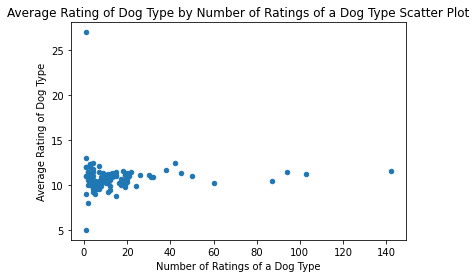

In [41]:

df_plot.plot(x='dog_type_count', y='dog_type_mean', kind='scatter')
plt.xlabel('Number of Ratings of a Dog Type')
plt.ylabel('Average Rating of Dog Type')
plt.title('Average Rating of Dog Type by Number of Ratings of a Dog Type Scatter Plot')

fig = plt.gcf()
#plt.savefig('X:/' + newName + '.png', 
fig.savefig('output2.png',bbox_inches='tight');

Insight: Dog types with low number of ratings show a high variaty of mean ratings.